#### Timeseries required (example)
1. Generate initial Hurst exp (H_0) using one month worth of 1hr data (672 datapoints). Use entire november data to generate H_0
2. Then, generate Hurst exp time series from H_0 for the month of Dec. This will result in 672 1hr data points of Hurst exp for Dec.
3. We need to feed in 3 times series into the back tester (all in Dec):
    - Price series of underlying 
    - Price series of perp swap
    - Hurst exp
4. Create strategy for mean reversion:
    - start trading only when hurst is below 0.5 (mean reverting)
    - incorporate bollinger bands to make hurst strat more robust

## Strategy
When price is inside Bollinger Band (BB):
- H > 0.5 -> hedge by long/short perp in opposite direction of underlying
- if rebound from upper BB + H < 0.5 -> short underlying
- if rebound from lower BB + H < 0.5 -> long underlying

When price is above Bollinger band:
- if H > 0.5 -> inaction
- if H < 0.5 + cross BB -> short underlying

When price is below Bollinger band
- if H > 0.5 -> inaction
- if H < 0.5 + cross BB -> long underlying

In general, when price is outside BB, take action only when H < 0.5 (mean reverting). When inside BB, hedge with perp in opposite direction only when H > 0.5 (trending)

Timeframe to generate H: 1 week

- test multiple timeframes and see how the strategies work in different timeframes

- Entry: Bollinger band upper and bottom limit
- We use the timestamp's volume to compare with its rolling volume for a week. If the volume > the rolling volume, more market movement to be anticipated.

# Rescaled Range Analysis

In [52]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set_theme()
import backtrader as bt
from backtrader.feeds import PandasData
import warnings
warnings.filterwarnings('ignore')

## Fetch Data from Pickle files

In [53]:
# read spot data
df_spot = pd.read_pickle('../data/overall.pkl')

# read perp data
df_perp = pd.read_pickle('../data/perp_overall.pkl')

print(df_spot.ticker.unique(), df_perp.ticker.unique(), df_spot.columns)

['BINANCE_SPOT_BTC_USDT' 'BINANCE_SPOT_ETH_USDT' 'BINANCE_SPOT_BNB_USDT'
 'BINANCE_SPOT_ADA_USDT' 'BINANCE_SPOT_XRP_USDT' 'BINANCE_SPOT_MATIC_USDT'
 'BINANCE_SPOT_SOL_USDT' 'BINANCE_SPOT_UNI_USDT' 'BINANCE_SPOT_AVAX_USDT'] ['BINANCEFTS_PERP_BTC_USDT' 'BINANCEFTS_PERP_ADA_USDT'
 'BINANCEFTS_PERP_ETH_USDT' 'BINANCEFTS_PERP_XRP_USDT'
 'BINANCEFTS_PERP_DOGE_USDT' 'BINANCEFTS_PERP_SOL_USDT'
 'BINANCEFTS_PERP_UNI_USDT' 'BINANCEFTS_PERP_AVAX_USDT'
 'BINANCEFTS_PERP_MATIC_USDT' 'BINANCEFTS_PERP_BNB_USDT'] Index(['time_period_start', 'time_period_end', 'time_open', 'time_close',
       'price_open', 'price_high', 'price_low', 'price_close', 'volume_traded',
       'trades_count', 'ticker'],
      dtype='object')


In [68]:
class Wrangler:

    # hurst exponent through rescaled range
    @classmethod
    def hurst_rs(cls, ts):
        ts = np.array(ts)
        # N is use for storge the length sequence
        total_len, rescaled_range, ts_len = [], [], len(ts)
        while True:
            total_len.append(ts_len)
            # calculate mean 
            m = np.mean(ts)
            # calculate mean deviation
            mean_dev = ts - m
            # Construct cumulative deviation sequence
            cumulative_dvi = np.cumsum(mean_dev)
            # Calculate max_diff
            max_diff = max(cumulative_dvi) - min(cumulative_dvi)
            # Calculate the unbiased standard deviation of this sequence
            unbiased_std_dvi = np.std(ts)
            # Calculate the rescaled range of this sequence under n length
            rescaled_range.append(max_diff / unbiased_std_dvi)
            # While n < 4 then break
            if ts_len < 4:
                break
            # Rebuild this sequence by half length
            ts, ts_len = cls.half_series(ts, ts_len)
            # Get Hurst-index by fit log(RS)~log(n)
            hurst_slope = np.polyfit(np.log10(total_len), np.log10(rescaled_range), 1)[0]
        return hurst_slope

    # helper function for hurst_slope
    def half_series(s, n):
    # ''' if length(X) is odd: X <- {(X1 + X2) / 2, ..., (Xn-2 + Xn-1) / 2, Xn} n <- (n - 1) / 2 else: X <- {(X1 + X2) / 2, ..., (Xn-1 + Xn) / 2} n <- n / 2 return X, n '''
        x = []
        for i in range(0, len(s) - 1, 2):
            x.append((s[i] + s[i + 1]) / 2)
        # if length(s) is odd
            if len(s) % 2 != 0:
                x.append(s[-1])
                n = (n - 1) // 2
            else:
                n = n // 2
        return [np.array(x), n]

    ## choose the ticker inside the dataframe
    @staticmethod
    def get_backtest_ticker_df(df: pd.DataFrame, ticker: str, start_dt: str, end_dt: str, with_returns=True) -> pd.DataFrame:
        data = df.loc[(df['ticker'] == ticker) & (df['time_period_start'] >= start_dt) & (df['time_period_start'] <= end_dt)]
        data = data[['time_period_start', 'price_open', 'price_high', 'price_low', 'price_close', 'volume_traded']]
        data.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']
        data.set_index('DateTime', inplace=True)
        if with_returns: data['ret'] = data['Close'].pct_change()

        return data

    @classmethod
    def get_backtest_ticker_with_hurst_df(cls, df: pd.DataFrame, ticker: str, start_dt: str, end_dt: str, rolling_window: int) -> pd.DataFrame:
        df = cls.get_backtest_ticker_df(df, ticker, start_dt, end_dt)
        df[f'hurst_{rolling_window}'] = df['Close'].rolling(rolling_window).apply(cls.hurst_rs)

        return df

    @classmethod
    def get_all_backtest_ticker_dict(cls, df_spot: pd.DataFrame, df_perp: pd.DataFrame, start_dt: str, end_dt: str) -> dict:
        backtest_dict = {spot_ticker.split('_')[2]: {
            'spot': cls.get_backtest_ticker_df(df_spot, ticker=spot_ticker, start_dt=start_dt, end_dt=end_dt),
            'perp': cls.get_backtest_ticker_df(df_perp, ticker=perp_ticker, start_dt=start_dt, end_dt=end_dt, with_returns=False)
        } for spot_ticker, perp_ticker in zip(df_spot.ticker.unique(), df_perp.ticker.unique())}
        
        return backtest_dict
    
    @classmethod
    def get_all_backtest_ticker_with_hurst_dict(cls, df_spot: pd.DataFrame, df_perp: pd.DataFrame, start_dt: str, end_dt: str, rolling_window: int):
        backtest_dict = cls.get_all_backtest_ticker_dict(df_spot, df_perp, start_dt, end_dt)
        ticker_list = list(backtest_dict.keys())
        for ticker in ticker_list:
            df = backtest_dict[ticker]['spot']
            df[f'hurst_{rolling_window}'] = df['Close'].rolling(rolling_window).apply(cls.hurst_rs)

        return backtest_dict

In [70]:
Wrangler.get_all_backtest_ticker_with_hurst_dict(df_spot, df_perp, '2020-11-01', '2022-08-01', 672)

{'BTC': {'spot':                                Open      High       Low     Close  \
  DateTime                                                            
  2020-11-01 00:00:00+00:00  13791.00  13895.00  13660.00  13725.95   
  2020-11-01 01:00:00+00:00  13725.96  13772.02  13707.68  13759.90   
  2020-11-01 02:00:00+00:00  13759.91  13774.96  13686.14  13715.88   
  2020-11-01 03:00:00+00:00  13715.88  13733.90  13641.00  13690.01   
  2020-11-01 04:00:00+00:00  13690.01  13701.05  13603.00  13677.25   
  ...                             ...       ...       ...       ...   
  2022-07-31 20:00:00+00:00  23843.69  23892.43  23772.75  23797.15   
  2022-07-31 21:00:00+00:00  23797.22  23827.25  23531.61  23589.58   
  2022-07-31 22:00:00+00:00  23591.06  23593.45  23227.31  23377.48   
  2022-07-31 23:00:00+00:00  23379.82  23469.00  23266.60  23293.32   
  2022-08-01 00:00:00+00:00  23296.36  23394.97  23257.37  23374.96   
  
                                  Volume       ret  hurst_6

## Timeframe analysis of H
- test different number of H

In [40]:
# testing for different number of H's
per_day = int(24)
hurst_periods = [7*per_day, 14*per_day,
                 30*per_day, 90*per_day, 180*per_day,
                 270*per_day]

# to aug 
btc_data = get_backtest_ticker_df(df_spot, ticker='BINANCE_SPOT_BTC_USDT', start_dt='2020-11-01', end_dt='2022-08-01')

copy_btc_data = btc_data.copy()

In [41]:
# copy_btc_data
copy_btc_data = copy_btc_data.resample("4H").agg({
        "Open": "first",
        "High": "max",
        "Low": "min",
        "Close": "last",
        "Volume": "last",
        "ret": "sum"
    })

In [50]:
per_day = int(6)
hurst_periods = [7*per_day, 14*per_day,
                 30*per_day, 90*per_day, 180*per_day,
                 270*per_day]


for period in hurst_periods:
    copy_btc_data[f'hurst_{str(period)}'] = copy_btc_data['Close'].rolling(period).apply(hurst_rs)

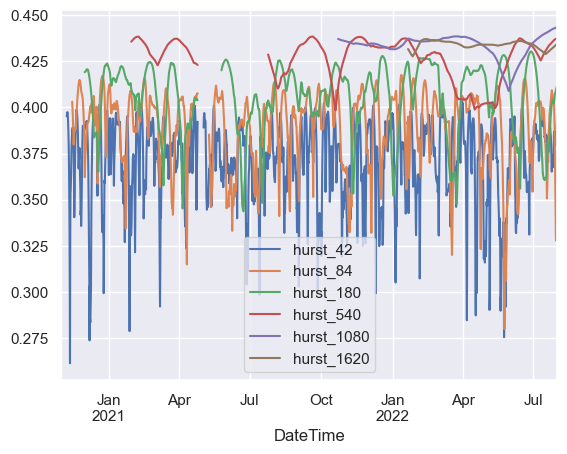

In [51]:
copy_btc_data.iloc[:, -6:].plot()

In [ ]:
for period in hurst_periods:
    btc_data[f'hurst_{str(period)}'] = btc_data['Close'].rolling(period).apply(hurst_rs)

#### Detrended Fluctuation Analysis (DFA)
https://raposa.trade/blog/find-your-best-market-to-trade-with-the-hurst-exponent/

#### Rescaled Range (R/S) Analysis (rolling window)

## Wrangle for Backtest Data

### Testing cerebro for btc-usdt

In [123]:
# https://www.backtrader.com/docu/pandas-datafeed/pandas-datafeed/
# 
class PandasData(bt.feeds.PandasData):
    lines = ('ret', 'hurst_rs', )
    params = (
        ('ret', 'ret'),
        ('hurst_rs', 'hurst_rs')
    )
    datafields = bt.feeds.PandasData.datafields + (['ret', 'hurst_rs'])

class HurstExp(bt.Indicator):
    lines = ('hurst',)

    def __init__(self):
        self.lines.hurst = self.data.hurst_rs
    
class St(bt.Strategy):
    def __init__(self):
        # self.sma = bt.indicators.SimpleMovingAverage(self.data)
        self.bb = bt.indicators.BollingerBands(self.data)
        self.hurst = HurstExp(self.data)

In [124]:
cerebro = bt.Cerebro()

# data1 = PandasData(dataname=proper_btc)
# cerebro.adddata(data1)

data = PandasData(dataname=btc_df_for_backtrader)
cerebro.adddata(data)

cerebro.addstrategy(St)
cerebro.run()

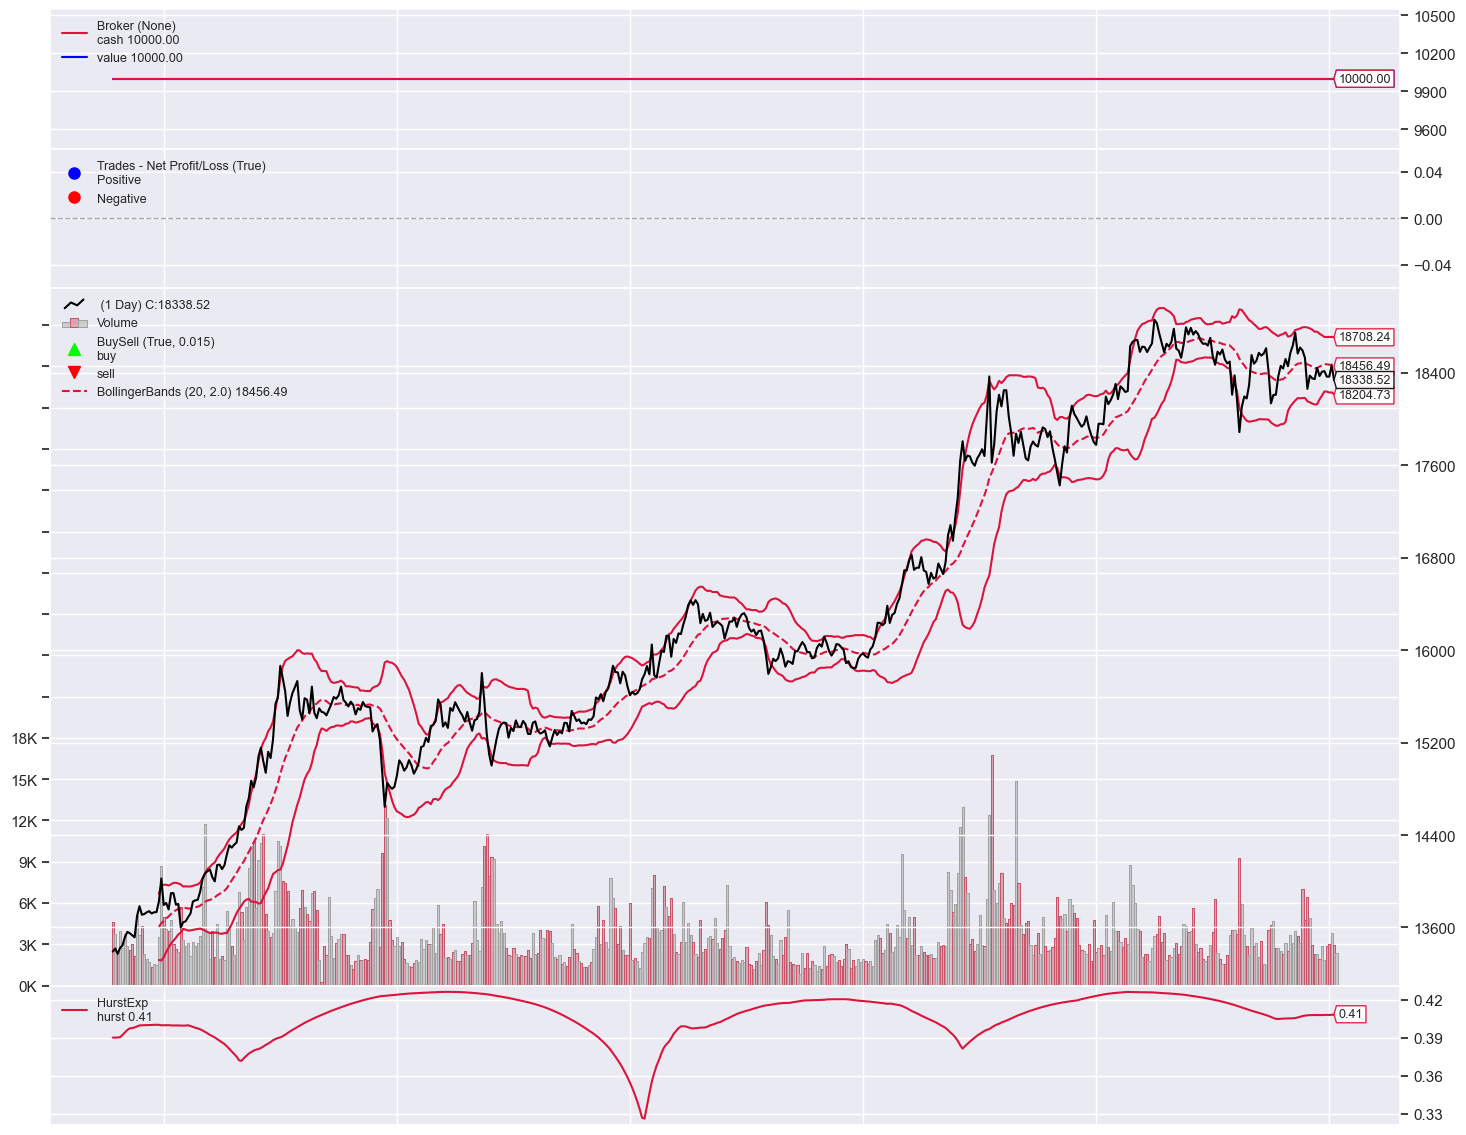

[[<Figure size 1500x1200 with 5 Axes>]]

In [125]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 12]
cerebro.plot(iplot=False)
# plt.rcParams.update({'font.size': 12}) 
# cerebro.plot(volume=False, iplot = False)

Hurst exponent = 0.3 for the Nov-2020 for btc_usdt
- likely to reverse trend over time?